In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
from matplotlib import patches
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

import os
import math
import random

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.metrics import roc_curve, roc_auc_score, auc

import scipy.stats as st
from scipy.stats import poisson
from scipy.interpolate import interp1d
from scipy.stats import norm


from sklearn.neighbors import KernelDensity 
from sklearn.model_selection import GridSearchCV

import scipy.integrate as integrate


import xgboost
from xgboost import XGBRegressor, XGBClassifier

In [85]:
Wgamma_fidcross  = 599.9768515734306
Wjets_fidcross   = 648.9972420521739
ttgamma_fidcross = 16.744584461333332
B_fidcross_tot   = Wgamma_fidcross + Wjets_fidcross + ttgamma_fidcross
B_fidcross_tot

1265.7186780869376

In [86]:
sample = 200000 # Number of signal and background events to plot their distributions

Wgamma_sample  = int(round(sample * Wgamma_fidcross / B_fidcross_tot))
Wjets_sample   = int(round(sample * Wjets_fidcross / B_fidcross_tot))
ttgamma_sample = int(round(sample * ttgamma_fidcross / B_fidcross_tot))

print(Wgamma_sample)
print(Wjets_sample)
print(ttgamma_sample)

94804
102550
2646


In [87]:
##############
# input data #
##############

# photon -> (pT, eta, phi) from the leading photon
# jet -> (pT, eta, phi) from the leading jet
# lepton -> (pT, eta, phi) from the lepton (electron or muon)
# MET -> (pT, eta, phi) eta = 0 by construction, but phi is important because we have a lot of jets that we do not use
# hadinfo -> (HT, num_jets)  HT: sum PT of all the jets, number of jets (b-tag or not)


######
# SM #
######

# W gamma + W gamma jet #
# Dominant # Np es el W jet el dominant??

datFolderWgamma = '../data/Wgamma/'

photon_Wgamma  = np.loadtxt(datFolderWgamma + 'photon.dat', delimiter=' ')
jet_Wgamma     = np.loadtxt(datFolderWgamma + 'jet.dat', delimiter=' ')
lepton_Wgamma  = np.loadtxt(datFolderWgamma + 'lepton.dat', delimiter=' ')
MET_Wgamma     = np.loadtxt(datFolderWgamma + 'MET.dat', delimiter=' ')
hadinfo_Wgamma = np.loadtxt(datFolderWgamma + 'hadinfo.dat', delimiter=' ')


# W jet + W jet jet #

datFolderWjets = '../data/Wjets/'

photon_Wjets  = np.loadtxt(datFolderWjets + 'photon.dat', delimiter=' ')
jet_Wjets     = np.loadtxt(datFolderWjets + 'jet.dat', delimiter=' ')
lepton_Wjets  = np.loadtxt(datFolderWjets + 'lepton.dat', delimiter=' ')
MET_Wjets     = np.loadtxt(datFolderWjets + 'MET.dat', delimiter=' ')
hadinfo_Wjets = np.loadtxt(datFolderWjets + 'hadinfo.dat', delimiter=' ')


# tt gamma + tt gamma jet #

datFolderttgamma = '../data/ttGamma/'
 
photon_ttgamma  = np.loadtxt(datFolderttgamma + 'photon.dat', delimiter=' ')
jet_ttgamma     = np.loadtxt(datFolderttgamma + 'jet.dat', delimiter=' ')
lepton_ttgamma  = np.loadtxt(datFolderttgamma + 'lepton.dat', delimiter=' ')
MET_ttgamma     = np.loadtxt(datFolderttgamma + 'MET.dat', delimiter=' ')
hadinfo_ttgamma = np.loadtxt(datFolderttgamma + 'hadinfo.dat', delimiter=' ')


photon_SM  = np.concatenate([photon_Wgamma[:Wgamma_sample], photon_Wjets[:Wjets_sample], photon_ttgamma[:ttgamma_sample]])
jet_SM     = np.concatenate([jet_Wgamma[:Wgamma_sample], jet_Wjets[:Wjets_sample], jet_ttgamma[:ttgamma_sample]]) 
lepton_SM  = np.concatenate([lepton_Wgamma[:Wgamma_sample], lepton_Wjets[:Wjets_sample], lepton_ttgamma[:ttgamma_sample]])
MET_SM     = np.concatenate([MET_Wgamma[:Wgamma_sample], MET_Wjets[:Wjets_sample], MET_ttgamma[:ttgamma_sample]])
hadinfo_SM = np.concatenate([hadinfo_Wgamma[:Wgamma_sample], hadinfo_Wjets[:Wjets_sample], hadinfo_ttgamma[:ttgamma_sample]])


In [222]:
bkg_flag = np.zeros(2*len(photon_SM))

bkg_flag[:len(photon_Wgamma[:Wgamma_sample])] = 1
bkg_flag[len(photon_Wgamma[:Wgamma_sample]):len(photon_Wjets[:Wjets_sample])] = 2
bkg_flag[(len(photon_Wgamma[:Wgamma_sample]) + len(photon_Wjets[:Wjets_sample])):len(photon_SM)] = 3

In [88]:
os.listdir('../data/Signal/')

['BP2_jet.dat',
 'BP14_lepton.dat',
 'BP3_MET.dat',
 'BP12_photon.dat',
 'BP13_MET.dat',
 'BP11_hadinfo.dat',
 'BP4_hadinfo.dat',
 'BP9_MET.dat',
 'BP8_photon.dat',
 'BP7_photon.dat',
 'BP3_photon.dat',
 'BP11_lepton.dat',
 'BP10_MET.dat',
 'BP15_photon.dat',
 'BP13_photon.dat',
 'BP3_jet.dat',
 'BP5_photon.dat',
 'BP5_jet.dat',
 'BP2_MET.dat',
 'BP2_hadinfo.dat',
 'BP6_lepton.dat',
 'BP1_MET.dat',
 'BP9_hadinfo.dat',
 'BP10_hadinfo.dat',
 'BP11_photon.dat',
 'BP7_jet.dat',
 'BP13_lepton.dat',
 'BP8_lepton.dat',
 'BP4_jet.dat',
 'BP8_MET.dat',
 'lhco',
 'BP14_photon.dat',
 'BP6_jet.dat',
 'BP1_jet.dat',
 'BP2_photon.dat',
 'BP5_lepton.dat',
 'BP3_hadinfo.dat',
 'BP2_lepton.dat',
 'BP15_MET.dat',
 'BP1_photon.dat',
 'BP9_jet.dat',
 'BP15_hadinfo.dat',
 'BP4_lepton.dat',
 'BP9_lepton.dat',
 'BP13_hadinfo.dat',
 'BP12_lepton.dat',
 'BP1_lepton.dat',
 'BP14_jet.dat',
 'BP13_jet.dat',
 'BP15_lepton.dat',
 'BP8_hadinfo.dat',
 'BP6_photon.dat',
 'BP7_MET.dat',
 'BP5_MET.dat',
 'BP10_photon.da

In [89]:
######
# NP #
######

datFolderNP = '../data/Signal/'

photon_NP  = []
jet_NP     = []
lepton_NP  = []
MET_NP     = []
hadinfo_NP = []
name       = []
for i in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]:
    name.append('BP' + str(i))
    photon_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '_photon.dat', delimiter=' ') )
    jet_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '_jet.dat', delimiter=' ') )
    lepton_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '_lepton.dat', delimiter=' ') )
    MET_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '_MET.dat', delimiter=' ') )
    hadinfo_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '_hadinfo.dat', delimiter=' ') )

In [90]:
print('SM', jet_SM.shape)
for i in range(len(jet_NP)):
    print(name[i], jet_NP[i].shape)

SM (200000, 3)
BP1 (250961, 3)
BP2 (258982, 3)
BP3 (180806, 3)
BP4 (316976, 3)
BP5 (279402, 3)
BP6 (212020, 3)
BP7 (331084, 3)
BP8 (293092, 3)
BP9 (235472, 3)
BP10 (341366, 3)
BP11 (304945, 3)
BP12 (254226, 3)
BP13 (349357, 3)
BP14 (313743, 3)
BP15 (268429, 3)


In [91]:
# other variables, individual channels:

HT_main_Wgamma = photon_Wgamma[:,0]+lepton_Wgamma[:,0]+jet_Wgamma[:,0]

MET_sig_Wgamma = np.divide( MET_Wgamma[:,0],np.sqrt(HT_main_Wgamma) )

m_eff_Wgamma = MET_Wgamma[:,0] + photon_Wgamma[:,0]+lepton_Wgamma[:,0]+jet_Wgamma[:,0]

phi_MET_photon_Wgamma = np.absolute( MET_Wgamma[:,2] - photon_Wgamma[:,2] )
phi_MET_jet_Wgamma = np.absolute( MET_Wgamma[:,2] - jet_Wgamma[:,2] )
phi_MET_lepton_Wgamma = np.absolute( MET_Wgamma[:,2] - lepton_Wgamma[:,2] )

mT_photon_Wgamma = np.sqrt( (2*photon_Wgamma[:,0]*MET_Wgamma[:,0]) * (1 - np.cos(phi_MET_photon_Wgamma)) )
mT_jet_Wgamma = np.sqrt( (2*jet_Wgamma[:,0]*MET_Wgamma[:,0]) * (1 - np.cos(phi_MET_jet_Wgamma)) )
mT_lepton_Wgamma = np.sqrt( (2*lepton_Wgamma[:,0]*MET_Wgamma[:,0]) * (1 - np.cos(phi_MET_lepton_Wgamma)) )

phi_photon_jet_Wgamma = np.absolute( photon_Wgamma[:,2] - jet_Wgamma[:,2] )
phi_photon_lepton_Wgamma = np.absolute( photon_Wgamma[:,2] - lepton_Wgamma[:,2] )
phi_lepton_jet_Wgamma = np.absolute( lepton_Wgamma[:,2] - jet_Wgamma[:,2] )

phi_photon_jet_Wgamma[phi_photon_jet_Wgamma>np.pi] = (2.* np.pi) - phi_photon_jet_Wgamma[phi_photon_jet_Wgamma>np.pi]
phi_photon_lepton_Wgamma[phi_photon_lepton_Wgamma>np.pi] = (2.* np.pi) - phi_photon_lepton_Wgamma[phi_photon_lepton_Wgamma>np.pi]
phi_lepton_jet_Wgamma[phi_lepton_jet_Wgamma>np.pi] = (2.* np.pi) - phi_lepton_jet_Wgamma[phi_lepton_jet_Wgamma>np.pi]

deltaR_photon_jet_Wgamma = np.sqrt( (photon_Wgamma[:,1]-jet_Wgamma[:,1])**2 + (phi_photon_jet_Wgamma)**2 )
deltaR_photon_lepton_Wgamma = np.sqrt( (photon_Wgamma[:,1]-lepton_Wgamma[:,1])**2 + (phi_photon_lepton_Wgamma)**2 )
deltaR_lepton_jet_Wgamma = np.sqrt( (lepton_Wgamma[:,1]-jet_Wgamma[:,1])**2 + (phi_lepton_jet_Wgamma)**2 )

HT_main_Wjets = photon_Wjets[:,0]+lepton_Wjets[:,0]+jet_Wjets[:,0]

MET_sig_Wjets = np.divide( MET_Wjets[:,0],np.sqrt(HT_main_Wjets) )

m_eff_Wjets = MET_Wjets[:,0] + photon_Wjets[:,0]+lepton_Wjets[:,0]+jet_Wjets[:,0]

phi_MET_photon_Wjets = np.absolute( MET_Wjets[:,2] - photon_Wjets[:,2] )
phi_MET_jet_Wjets = np.absolute( MET_Wjets[:,2] - jet_Wjets[:,2] )
phi_MET_lepton_Wjets = np.absolute( MET_Wjets[:,2] - lepton_Wjets[:,2] )

mT_photon_Wjets = np.sqrt( (2*photon_Wjets[:,0]*MET_Wjets[:,0]) * (1 - np.cos(phi_MET_photon_Wjets)) )
mT_jet_Wjets = np.sqrt( (2*jet_Wjets[:,0]*MET_Wjets[:,0]) * (1 - np.cos(phi_MET_jet_Wjets)) )
mT_lepton_Wjets = np.sqrt( (2*lepton_Wjets[:,0]*MET_Wjets[:,0]) * (1 - np.cos(phi_MET_lepton_Wjets)) )

phi_photon_jet_Wjets = np.absolute( photon_Wjets[:,2] - jet_Wjets[:,2] )
phi_photon_lepton_Wjets = np.absolute( photon_Wjets[:,2] - lepton_Wjets[:,2] )
phi_lepton_jet_Wjets = np.absolute( lepton_Wjets[:,2] - jet_Wjets[:,2] )

phi_photon_jet_Wjets[phi_photon_jet_Wjets>np.pi] = (2.* np.pi) - phi_photon_jet_Wjets[phi_photon_jet_Wjets>np.pi]
phi_photon_lepton_Wjets[phi_photon_lepton_Wjets>np.pi] = (2.* np.pi) - phi_photon_lepton_Wjets[phi_photon_lepton_Wjets>np.pi]
phi_lepton_jet_Wjets[phi_lepton_jet_Wjets>np.pi] = (2.* np.pi) - phi_lepton_jet_Wjets[phi_lepton_jet_Wjets>np.pi]

deltaR_photon_jet_Wjets = np.sqrt( (photon_Wjets[:,1]-jet_Wjets[:,1])**2 + (phi_photon_jet_Wjets)**2 )
deltaR_photon_lepton_Wjets = np.sqrt( (photon_Wjets[:,1]-lepton_Wjets[:,1])**2 + (phi_photon_lepton_Wjets)**2 )
deltaR_lepton_jet_Wjets = np.sqrt( (lepton_Wjets[:,1]-jet_Wjets[:,1])**2 + (phi_lepton_jet_Wjets)**2 )



HT_main_ttgamma = photon_ttgamma[:,0]+lepton_ttgamma[:,0]+jet_ttgamma[:,0]

MET_sig_ttgamma = np.divide( MET_ttgamma[:,0],np.sqrt(HT_main_ttgamma) )

m_eff_ttgamma = MET_ttgamma[:,0] + photon_ttgamma[:,0]+lepton_ttgamma[:,0]+jet_ttgamma[:,0]

phi_MET_photon_ttgamma = np.absolute( MET_ttgamma[:,2] - photon_ttgamma[:,2] )
phi_MET_jet_ttgamma = np.absolute( MET_ttgamma[:,2] - jet_ttgamma[:,2] )
phi_MET_lepton_ttgamma = np.absolute( MET_ttgamma[:,2] - lepton_ttgamma[:,2] )

mT_photon_ttgamma = np.sqrt( (2*photon_ttgamma[:,0]*MET_ttgamma[:,0]) * (1 - np.cos(phi_MET_photon_ttgamma)) )
mT_jet_ttgamma = np.sqrt( (2*jet_ttgamma[:,0]*MET_ttgamma[:,0]) * (1 - np.cos(phi_MET_jet_ttgamma)) )
mT_lepton_ttgamma = np.sqrt( (2*lepton_ttgamma[:,0]*MET_ttgamma[:,0]) * (1 - np.cos(phi_MET_lepton_ttgamma)) )

phi_photon_jet_ttgamma = np.absolute( photon_ttgamma[:,2] - jet_ttgamma[:,2] )
phi_photon_lepton_ttgamma = np.absolute( photon_ttgamma[:,2] - lepton_ttgamma[:,2] )
phi_lepton_jet_ttgamma = np.absolute( lepton_ttgamma[:,2] - jet_ttgamma[:,2] )

phi_photon_jet_ttgamma[phi_photon_jet_ttgamma>np.pi] = (2.* np.pi) - phi_photon_jet_ttgamma[phi_photon_jet_ttgamma>np.pi]
phi_photon_lepton_ttgamma[phi_photon_lepton_ttgamma>np.pi] = (2.* np.pi) - phi_photon_lepton_ttgamma[phi_photon_lepton_ttgamma>np.pi]
phi_lepton_jet_ttgamma[phi_lepton_jet_ttgamma>np.pi] = (2.* np.pi) - phi_lepton_jet_ttgamma[phi_lepton_jet_ttgamma>np.pi]

deltaR_photon_jet_ttgamma = np.sqrt( (photon_ttgamma[:,1]-jet_ttgamma[:,1])**2 + (phi_photon_jet_ttgamma)**2 )
deltaR_photon_lepton_ttgamma = np.sqrt( (photon_ttgamma[:,1]-lepton_ttgamma[:,1])**2 + (phi_photon_lepton_ttgamma)**2 )
deltaR_lepton_jet_ttgamma = np.sqrt( (lepton_ttgamma[:,1]-jet_ttgamma[:,1])**2 + (phi_lepton_jet_ttgamma)**2 )



# other variables

HT_main_SM = photon_SM[:,0]+lepton_SM[:,0]+jet_SM[:,0]

MET_sig_SM = np.divide( MET_SM[:,0],np.sqrt(HT_main_SM) )

m_eff_SM = MET_SM[:,0] + photon_SM[:,0]+lepton_SM[:,0]+jet_SM[:,0]

phi_MET_photon_SM = np.absolute( MET_SM[:,2] - photon_SM[:,2] )
phi_MET_jet_SM    = np.absolute( MET_SM[:,2] - jet_SM[:,2] )
phi_MET_lepton_SM = np.absolute( MET_SM[:,2] - lepton_SM[:,2] )

mT_photon_SM = np.sqrt( (2*photon_SM[:,0]*MET_SM[:,0]) * (1 - np.cos(phi_MET_photon_SM)) )
mT_jet_SM    = np.sqrt( (2*jet_SM[:,0]*MET_SM[:,0]) * (1 - np.cos(phi_MET_jet_SM)) )
mT_lepton_SM = np.sqrt( (2*lepton_SM[:,0]*MET_SM[:,0]) * (1 - np.cos(phi_MET_lepton_SM)) )

phi_photon_jet_SM    = np.absolute( photon_SM[:,2] - jet_SM[:,2] )
phi_photon_lepton_SM = np.absolute( photon_SM[:,2] - lepton_SM[:,2] )
phi_lepton_jet_SM    = np.absolute( lepton_SM[:,2] - jet_SM[:,2] )

phi_photon_jet_SM[phi_photon_jet_SM>np.pi]       = (2.* np.pi) - phi_photon_jet_SM[phi_photon_jet_SM>np.pi]
phi_photon_lepton_SM[phi_photon_lepton_SM>np.pi] = (2.* np.pi) - phi_photon_lepton_SM[phi_photon_lepton_SM>np.pi]
phi_lepton_jet_SM[phi_lepton_jet_SM>np.pi]       = (2.* np.pi) - phi_lepton_jet_SM[phi_lepton_jet_SM>np.pi]

deltaR_photon_jet_SM    = np.sqrt( (photon_SM[:,1]-jet_SM[:,1])**2 + (phi_photon_jet_SM)**2 )
deltaR_photon_lepton_SM = np.sqrt( (photon_SM[:,1]-lepton_SM[:,1])**2 + (phi_photon_lepton_SM)**2 )
deltaR_lepton_jet_SM    = np.sqrt( (lepton_SM[:,1]-jet_SM[:,1])**2 + (phi_lepton_jet_SM)**2 )

In [92]:
# other variables NEW PHYSICS
HT_main_NP = []
MET_sig_NP = []
m_eff_NP   = []

phi_MET_photon_NP = []
phi_MET_jet_NP    = []
phi_MET_lepton_NP = []

mT_photon_NP = []
mT_jet_NP    = []
mT_lepton_NP = []

phi_photon_jet_NP    = []
phi_photon_lepton_NP = []
phi_lepton_jet_NP    = []

phi_photon_jet_NP    = []
phi_photon_lepton_NP = []
phi_lepton_jet_NP    = []

deltaR_photon_jet_NP    = []
deltaR_photon_lepton_NP = []
deltaR_lepton_jet_NP    = []

for i in range(len(photon_NP)):
    HT_main_NP.append( photon_NP[i][:,0] + lepton_NP[i][:,0] + jet_NP[i][:,0] )

    MET_sig_NP.append( np.divide( MET_NP[i][:,0],np.sqrt(HT_main_NP[i]) ) )

    m_eff_NP.append( MET_NP[i][:,0] + photon_NP[i][:,0] + lepton_NP[i][:,0] + jet_NP[i][:,0] )

    phi_MET_photon_NP.append( np.absolute( MET_NP[i][:,2] - photon_NP[i][:,2] ) )
    phi_MET_jet_NP.append( np.absolute( MET_NP[i][:,2] - jet_NP[i][:,2] ) )
    phi_MET_lepton_NP.append( np.absolute( MET_NP[i][:,2] - lepton_NP[i][:,2] ) )

    mT_photon_NP.append( np.sqrt( (2*photon_NP[i][:,0]*MET_NP[i][:,0]) * (1 - np.cos(phi_MET_photon_NP[i])) ) )
    mT_jet_NP.append( np.sqrt( (2*jet_NP[i][:,0]*MET_NP[i][:,0]) * (1 - np.cos(phi_MET_jet_NP[i])) ) )
    mT_lepton_NP.append( np.sqrt( (2*lepton_NP[i][:,0]*MET_NP[i][:,0]) * (1 - np.cos(phi_MET_lepton_NP[i])) ) )

    phi_photon_jet_NP.append( np.absolute( photon_NP[i][:,2] - jet_NP[i][:,2] ) )
    phi_photon_lepton_NP.append( np.absolute( photon_NP[i][:,2] - lepton_NP[i][:,2] ) )
    phi_lepton_jet_NP.append( np.absolute( lepton_NP[i][:,2] - jet_NP[i][:,2] ) )

    phi_photon_jet_NP[i][phi_photon_jet_NP[i] > np.pi]       = (2.* np.pi) - phi_photon_jet_NP[i][phi_photon_jet_NP[i] > np.pi]
    phi_photon_lepton_NP[i][phi_photon_lepton_NP[i] > np.pi] = (2.* np.pi) - phi_photon_lepton_NP[i][phi_photon_lepton_NP[i] > np.pi]
    phi_lepton_jet_NP[i][phi_lepton_jet_NP[i] > np.pi]       = (2.* np.pi) - phi_lepton_jet_NP[i][phi_lepton_jet_NP[i] > np.pi]

    deltaR_photon_jet_NP.append( np.sqrt( (photon_NP[i][:,1]-jet_NP[i][:,1])**2 + (phi_photon_jet_NP[i])**2 ) )
    deltaR_photon_lepton_NP.append( np.sqrt( (photon_NP[i][:,1]-lepton_NP[i][:,1])**2 + (phi_photon_lepton_NP[i])**2 ) )
    deltaR_lepton_jet_NP.append( np.sqrt( (lepton_NP[i][:,1]-jet_NP[i][:,1])**2 + (phi_lepton_jet_NP[i])**2 ) )

In [93]:
print(photon_SM.shape)
print(photon_NP[0].shape)

(200000, 3)
(250961, 3)


# Plots

In [94]:
cmap = cm.get_cmap('viridis', len(photon_NP))

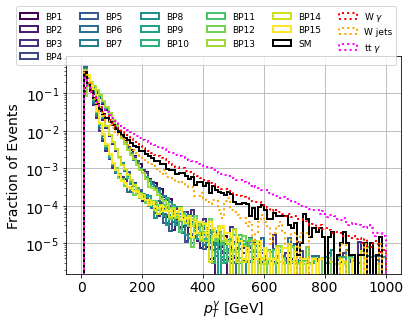

In [95]:
for i in range(len(photon_NP)):
    weights = np.ones_like(photon_NP[i][:,0])/len(photon_NP[i][:,0])
    plt.hist(photon_NP[i][:,0], weights=weights, bins=100, range=[0,1000], lw=2, edgecolor=cmap(i), histtype='step', label=name[i], zorder=2)

weights = np.ones_like(photon_SM[:,0])/len(photon_SM[:,0])
plt.hist(photon_SM[:,0], weights=weights, bins=100, range=[0,1000], lw=2, edgecolor='black', histtype='step', label="SM", zorder=2)
weights = np.ones_like(photon_Wgamma[:,0])/len(photon_Wgamma[:,0])
plt.hist(photon_Wgamma[:,0], weights=weights, bins=100, range=[0,1000], lw=2,linestyle='dotted', edgecolor='red', histtype='step', label=r"W $\gamma$")
weights = np.ones_like(photon_Wjets[:,0])/len(photon_Wjets[:,0])
plt.hist(photon_Wjets[:,0], weights=weights, bins=100, range=[0,1000], lw=2,linestyle='dotted', edgecolor='orange', histtype='step', label="W jets")
weights = np.ones_like(photon_ttgamma[:,0])/len(photon_ttgamma[:,0])
plt.hist(photon_ttgamma[:,0], weights=weights, bins=100, range=[0,1000], lw=2,linestyle='dotted', edgecolor='magenta', histtype='step', label="tt $\gamma$")

plt.grid()
plt.xlabel(r"$p_T^{\gamma}$ [GeV]",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.legend(loc='upper right',fontsize=9,bbox_to_anchor=(1., 1.25), ncol = 6)
plt.savefig('../graph/pt_leadingPhoton_dist.png', bbox_inches='tight')

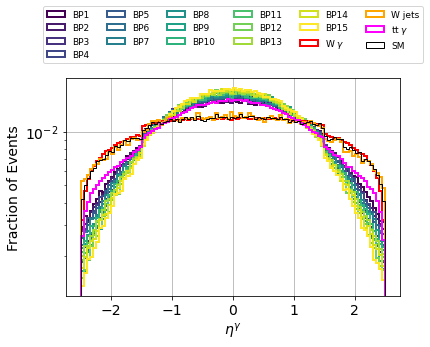

In [210]:
for i in range(len(photon_NP)):
    weights = np.ones_like(photon_NP[i][:,1])/len(photon_NP[i][:,1])
    plt.hist(photon_NP[i][:,1], weights=weights, bins=100, lw=2, edgecolor=cmap(i), histtype='step', label=name[i], zorder=2)

weights = np.ones_like(photon_Wgamma[:,1])/len(photon_Wgamma[:,1])
plt.hist(photon_Wgamma[:,1], weights=weights, bins=100, lw=2,linestyle='solid', edgecolor='red', histtype='step', label=r"W $\gamma$")
weights = np.ones_like(photon_Wjets[:,1])/len(photon_Wjets[:,1])
plt.hist(photon_Wjets[:,1], weights=weights, bins=100, lw=2,linestyle='solid', edgecolor='orange', histtype='step', label="W jets")
weights = np.ones_like(photon_ttgamma[:,1])/len(photon_ttgamma[:,1])
plt.hist(photon_ttgamma[:,1], weights=weights, bins=100, lw=2,linestyle='solid', edgecolor='magenta', histtype='step', label="tt $\gamma$")
weights = np.ones_like(photon_SM[:,1])/len(photon_SM[:,1])
plt.hist(photon_SM[:,1], weights=weights, bins=100, lw=1, edgecolor='black', histtype='step', label="SM", zorder=2)

plt.grid()  
plt.xlabel(r"$\eta^{\gamma}$",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.legend(loc='lower center',fontsize=9,bbox_to_anchor=(0.5, 1.05), ncol = 6)
plt.savefig('../graph/pseudoRapidity_leadingPhoton_dist.png', bbox_inches='tight')

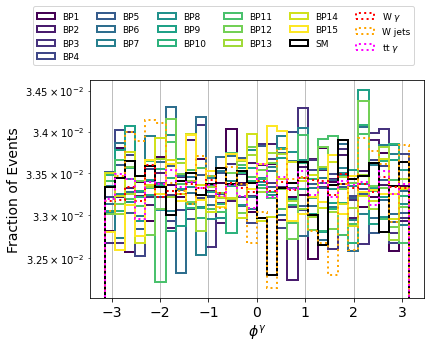

In [97]:
for i in range(len(photon_NP)):
    weights = np.ones_like(photon_NP[i][:,2])/len(photon_NP[i][:,2])
    plt.hist(photon_NP[i][:,2], weights=weights, bins=30, lw=2, edgecolor=cmap(i), histtype='step', label=name[i], zorder=2)

weights = np.ones_like(photon_SM[:,2])/len(photon_SM[:,2])
plt.hist(photon_SM[:,2], weights=weights, bins=30, lw=2, edgecolor='black', histtype='step', label="SM", zorder=2)
weights = np.ones_like(photon_Wgamma[:,2])/len(photon_Wgamma[:,2])
plt.hist(photon_Wgamma[:,2], weights=weights, bins=30, lw=2,linestyle='dotted', edgecolor='red', histtype='step', label=r"W $\gamma$")
weights = np.ones_like(photon_Wjets[:,2])/len(photon_Wjets[:,2])
plt.hist(photon_Wjets[:,2], weights=weights, bins=30, lw=2,linestyle='dotted', edgecolor='orange', histtype='step', label="W jets")
weights = np.ones_like(photon_ttgamma[:,2])/len(photon_ttgamma[:,2])
plt.hist(photon_ttgamma[:,2], weights=weights, bins=30, lw=2,linestyle='dotted', edgecolor='magenta', histtype='step', label="tt $\gamma$")

plt.grid()  
plt.xlabel(r"$\phi^{\gamma}$",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.legend(loc='lower center',fontsize=9,bbox_to_anchor=(0.4, 1.05), ncol = 6)
plt.savefig('../graph/phi_leadingPhoton_dist.png', bbox_inches='tight')

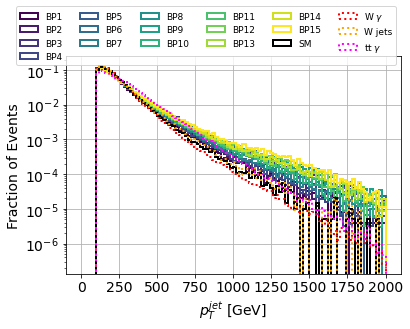

In [98]:
for i in range(len(photon_NP)):
    weights = np.ones_like(jet_NP[i][:,0])/len(jet_NP[i][:,0])
    plt.hist(jet_NP[i][:,0], weights=weights, bins=100, range=[0,2000], lw=2, edgecolor=cmap(i), histtype='step', label=name[i], zorder=2)

weights = np.ones_like(jet_SM[:,0])/len(jet_SM[:,0])
plt.hist(jet_SM[:,0], weights=weights, bins=100, range=[0,2000], lw=2, edgecolor='black', histtype='step', label="SM", zorder=2)
weights = np.ones_like(jet_Wgamma[:,0])/len(jet_Wgamma[:,0])
plt.hist(jet_Wgamma[:,0], weights=weights, bins=100, range=[0,2000], lw=2,linestyle='dotted', edgecolor='red', histtype='step', label=r"W $\gamma$")
weights = np.ones_like(jet_Wjets[:,0])/len(jet_Wjets[:,0])
plt.hist(jet_Wjets[:,0], weights=weights, bins=100, range=[0,2000], lw=2,linestyle='dotted', edgecolor='orange', histtype='step', label="W jets")
weights = np.ones_like(jet_ttgamma[:,0])/len(jet_ttgamma[:,0])
plt.hist(jet_ttgamma[:,0], weights=weights, bins=100, range=[0,2000], lw=2,linestyle='dotted', edgecolor='magenta', histtype='step', label="tt $\gamma$")

plt.grid()  
plt.xlabel(r"$p_T^{jet}$ [GeV]",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.legend(loc='upper right',fontsize=9,bbox_to_anchor=(1., 1.25), ncol = 6)
plt.savefig('../graph/pt_leadingJet_dist.png', bbox_inches='tight')

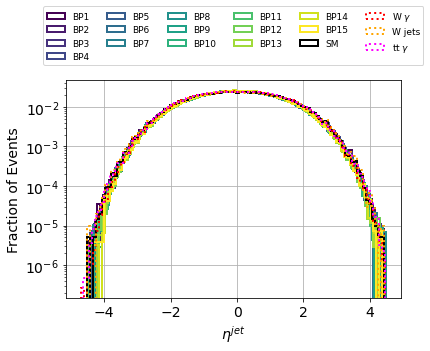

In [99]:
for i in range(len(photon_NP)):
    weights = np.ones_like(jet_NP[i][:,1])/len(jet_NP[i][:,1])
    plt.hist(jet_NP[i][:,1], weights=weights, bins=100, lw=2, edgecolor=cmap(i), histtype='step', label=name[i], zorder=2)

weights = np.ones_like(jet_SM[:,1])/len(jet_SM[:,1])
plt.hist(jet_SM[:,1], weights=weights, bins=100, lw=2, edgecolor='black', histtype='step', label="SM", zorder=2)
weights = np.ones_like(jet_Wgamma[:,1])/len(jet_Wgamma[:,1])
plt.hist(jet_Wgamma[:,1], weights=weights, bins=100, lw=2,linestyle='dotted', edgecolor='red', histtype='step', label=r"W $\gamma$")
weights = np.ones_like(jet_Wjets[:,1])/len(jet_Wjets[:,1])
plt.hist(jet_Wjets[:,1], weights=weights, bins=100, lw=2,linestyle='dotted', edgecolor='orange', histtype='step', label="W jets")
weights = np.ones_like(jet_ttgamma[:,1])/len(jet_ttgamma[:,1])
plt.hist(jet_ttgamma[:,1], weights=weights, bins=100, lw=2,linestyle='dotted', edgecolor='magenta', histtype='step', label="tt $\gamma$")

plt.grid()  
plt.xlabel(r"$\eta^{jet}$",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.legend(loc='lower center',fontsize=9,bbox_to_anchor=(0.5, 1.05), ncol = 6)
plt.savefig('../graph/pseudoRapidity_leadingJet_dist.png', bbox_inches='tight')

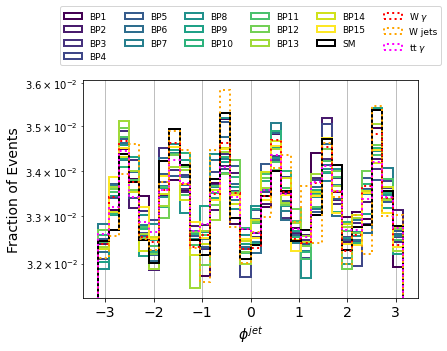

In [100]:
for i in range(len(photon_NP)):
    weights = np.ones_like(jet_NP[i][:,2])/len(jet_NP[i][:,2])
    plt.hist(jet_NP[i][:,2], weights=weights, bins=30, lw=2, edgecolor=cmap(i), histtype='step', label=name[i], zorder=2)

weights = np.ones_like(jet_SM[:,2])/len(jet_SM[:,2])
plt.hist(jet_SM[:,2], weights=weights, bins=30, lw=2, edgecolor='black', histtype='step', label="SM", zorder=2)
weights = np.ones_like(jet_Wgamma[:,2])/len(jet_Wgamma[:,2])
plt.hist(jet_Wgamma[:,2], weights=weights, bins=30, lw=2,linestyle='dotted', edgecolor='red', histtype='step', label=r"W $\gamma$")
weights = np.ones_like(jet_Wjets[:,2])/len(jet_Wjets[:,2])
plt.hist(jet_Wjets[:,2], weights=weights, bins=30, lw=2,linestyle='dotted', edgecolor='orange', histtype='step', label="W jets")
weights = np.ones_like(jet_ttgamma[:,2])/len(jet_ttgamma[:,2])
plt.hist(jet_ttgamma[:,2], weights=weights, bins=30, lw=2,linestyle='dotted', edgecolor='magenta', histtype='step', label="tt $\gamma$")

plt.grid()  
plt.xlabel(r"$\phi^{jet}$",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.legend(loc='lower center',fontsize=9,bbox_to_anchor=(0.5, 1.05), ncol = 6)
plt.savefig('../graph/phi_leadingJet_dist.png', bbox_inches='tight')

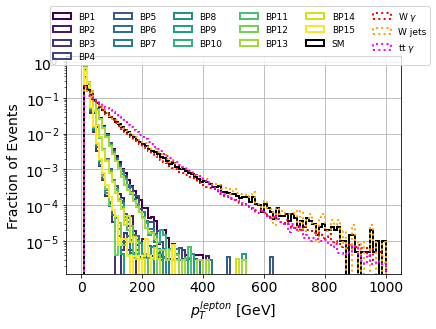

In [101]:
for i in range(len(photon_NP)):
    weights = np.ones_like(lepton_NP[i][:,0])/len(lepton_NP[i][:,0])
    plt.hist(lepton_NP[i][:,0], weights=weights, bins=100, range=[0,1000], lw=2, edgecolor=cmap(i), histtype='step', label=name[i], zorder=2)

weights = np.ones_like(lepton_SM[:,0])/len(lepton_SM[:,0])
plt.hist(lepton_SM[:,0], weights=weights, bins=100, range=[0,1000], lw=2, edgecolor='black', histtype='step', label="SM", zorder=2)
weights = np.ones_like(lepton_Wgamma[:,0])/len(lepton_Wgamma[:,0])
plt.hist(lepton_Wgamma[:,0], weights=weights, bins=100, range=[0,1000], lw=2,linestyle='dotted', edgecolor='red', histtype='step', label=r"W $\gamma$")
weights = np.ones_like(lepton_Wjets[:,0])/len(lepton_Wjets[:,0])
plt.hist(lepton_Wjets[:,0], weights=weights, bins=100, range=[0,1000], lw=2,linestyle='dotted', edgecolor='orange', histtype='step', label="W jets")
weights = np.ones_like(lepton_ttgamma[:,0])/len(lepton_ttgamma[:,0])
plt.hist(lepton_ttgamma[:,0], weights=weights, bins=100, range=[0,1000], lw=2,linestyle='dotted', edgecolor='magenta', histtype='step', label="tt $\gamma$")

plt.grid()  
plt.xlabel(r"$p_T^{lepton}$ [GeV]",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.legend(loc='upper right',fontsize=9,bbox_to_anchor=(1.1, 1.25), ncol = 6)
plt.savefig('../graph/pt_leadingLepton_dist.png', bbox_inches='tight')

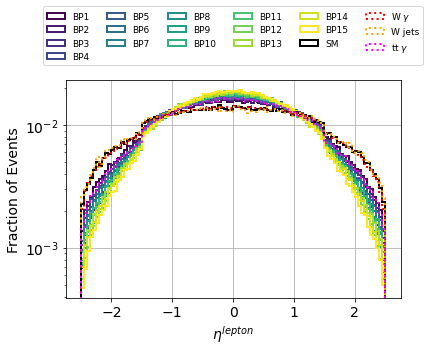

In [102]:
for i in range(len(photon_NP)):
    weights = np.ones_like(lepton_NP[i][:,1])/len(lepton_NP[i][:,1])
    plt.hist(lepton_NP[i][:,1], weights=weights, bins=100, lw=2, edgecolor=cmap(i), histtype='step', label=name[i], zorder=2)

weights = np.ones_like(lepton_SM[:,1])/len(lepton_SM[:,1])
plt.hist(lepton_SM[:,1], weights=weights, bins=100, lw=2, edgecolor='black', histtype='step', label="SM", zorder=2)
weights = np.ones_like(lepton_Wgamma[:,1])/len(lepton_Wgamma[:,1])
plt.hist(lepton_Wgamma[:,1], weights=weights, bins=100, lw=2,linestyle='dotted', edgecolor='red', histtype='step', label=r"W $\gamma$")
weights = np.ones_like(lepton_Wjets[:,1])/len(lepton_Wjets[:,1])
plt.hist(lepton_Wjets[:,1], weights=weights, bins=100, lw=2,linestyle='dotted', edgecolor='orange', histtype='step', label="W jets")
weights = np.ones_like(lepton_ttgamma[:,1])/len(lepton_ttgamma[:,1])
plt.hist(lepton_ttgamma[:,1], weights=weights, bins=100, lw=2,linestyle='dotted', edgecolor='magenta', histtype='step', label="tt $\gamma$")

plt.grid()  
plt.xlabel(r"$\eta^{lepton}$",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.legend(loc='lower center',fontsize=9,bbox_to_anchor=(0.5, 1.05), ncol = 6)
plt.savefig('../graph/pseudoRapidity_leadingLepton_dist.png', bbox_inches='tight')

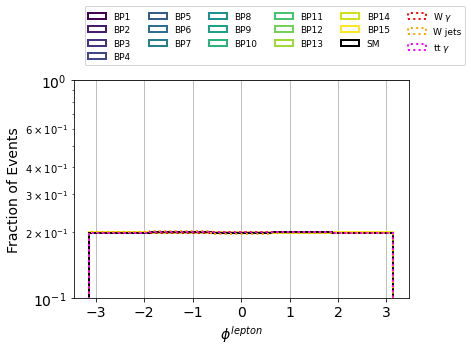

In [103]:
for i in range(len(photon_NP)):
    weights = np.ones_like(lepton_NP[i][:,2])/len(lepton_NP[i][:,2])
    plt.hist(lepton_NP[i][:,2], weights=weights, bins=5, lw=2, edgecolor=cmap(i), histtype='step', label=name[i], zorder=2)

weights = np.ones_like(lepton_SM[:,2])/len(lepton_SM[:,2])
plt.hist(lepton_SM[:,2], weights=weights, bins=5, lw=2, edgecolor='black', histtype='step', label="SM", zorder=2)
weights = np.ones_like(lepton_Wgamma[:,2])/len(lepton_Wgamma[:,2])
plt.hist(lepton_Wgamma[:,2], weights=weights, bins=5, lw=2,linestyle='dotted', edgecolor='red', histtype='step', label=r"W $\gamma$")
weights = np.ones_like(lepton_Wjets[:,2])/len(lepton_Wjets[:,2])
plt.hist(lepton_Wjets[:,2], weights=weights, bins=5, lw=2,linestyle='dotted', edgecolor='orange', histtype='step', label="W jets")
weights = np.ones_like(lepton_ttgamma[:,2])/len(lepton_ttgamma[:,2])
plt.hist(lepton_ttgamma[:,2], weights=weights, bins=5, lw=2,linestyle='dotted', edgecolor='magenta', histtype='step', label="tt $\gamma$")

plt.grid()  
plt.xlabel(r"$\phi^{lepton}$",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(0.1,1)
plt.yscale('log')
plt.legend(loc='lower center',fontsize=9,bbox_to_anchor=(0.6, 1.05), ncol = 6)
plt.savefig('../graph/phi_leadingLepton_dist.png', bbox_inches='tight')

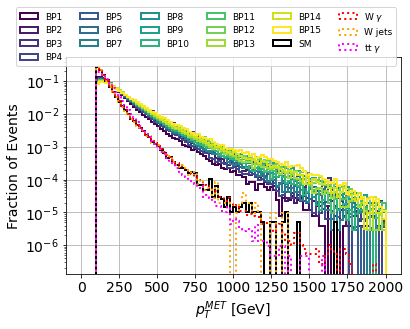

In [104]:
for i in range(len(photon_NP)):
    weights = np.ones_like(MET_NP[i][:,0])/len(MET_NP[i][:,0])
    plt.hist(MET_NP[i][:,0], weights=weights, bins=100, range=[0,2000], lw=2, edgecolor=cmap(i), histtype='step', label=name[i], zorder=2)

weights = np.ones_like(MET_SM[:,0])/len(MET_SM[:,0])
plt.hist(MET_SM[:,0], weights=weights, bins=100, range=[0,2000], lw=2, edgecolor='black', histtype='step', label="SM", zorder=2)
weights = np.ones_like(MET_Wgamma[:,0])/len(MET_Wgamma[:,0])
plt.hist(MET_Wgamma[:,0], weights=weights, bins=100, range=[0,2000], lw=2,linestyle='dotted', edgecolor='red', histtype='step', label=r"W $\gamma$")
weights = np.ones_like(MET_Wjets[:,0])/len(MET_Wjets[:,0])
plt.hist(MET_Wjets[:,0], weights=weights, bins=100, range=[0,2000], lw=2,linestyle='dotted', edgecolor='orange', histtype='step', label="W jets")
weights = np.ones_like(MET_ttgamma[:,0])/len(MET_ttgamma[:,0])
plt.hist(MET_ttgamma[:,0], weights=weights, bins=100, range=[0,2000], lw=2,linestyle='dotted', edgecolor='magenta', histtype='step', label="tt $\gamma$")

plt.grid()  
plt.xlabel(r"$p_T^{MET}$ [GeV]",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.legend(loc='upper right',fontsize=9,bbox_to_anchor=(1., 1.25), ncol = 6)
plt.savefig('../graph/pt_MET_dist.png', bbox_inches='tight')

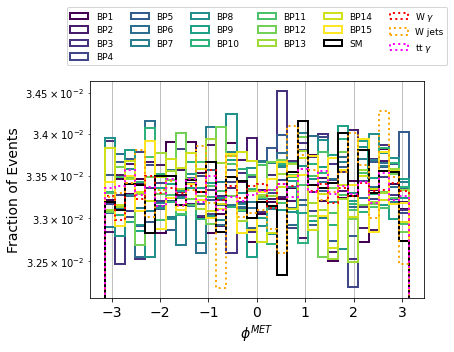

In [105]:
for i in range(len(photon_NP)):
    weights = np.ones_like(MET_NP[i][:,2])/len(MET_NP[i][:,2])
    plt.hist(MET_NP[i][:,2], weights=weights, bins=30, lw=2, edgecolor=cmap(i), histtype='step', label=name[i], zorder=2)

weights = np.ones_like(MET_SM[:,2])/len(MET_SM[:,2])
plt.hist(MET_SM[:,2], weights=weights, bins=30, lw=2, edgecolor='black', histtype='step', label="SM", zorder=2)
weights = np.ones_like(MET_Wgamma[:,2])/len(MET_Wgamma[:,2])
plt.hist(MET_Wgamma[:,2], weights=weights, bins=30, lw=2,linestyle='dotted', edgecolor='red', histtype='step', label=r"W $\gamma$")
weights = np.ones_like(MET_Wjets[:,2])/len(MET_Wjets[:,2])
plt.hist(MET_Wjets[:,2], weights=weights, bins=30, lw=2,linestyle='dotted', edgecolor='orange', histtype='step', label="W jets")
weights = np.ones_like(MET_ttgamma[:,2])/len(MET_ttgamma[:,2])
plt.hist(MET_ttgamma[:,2], weights=weights, bins=30, lw=2,linestyle='dotted', edgecolor='magenta', histtype='step', label="tt $\gamma$")

plt.grid()  
plt.xlabel(r"$\phi^{MET}$",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.legend(loc='lower center',fontsize=9,bbox_to_anchor=(0.5, 1.05), ncol = 6)
plt.savefig('../graph/phi_MET_dist.png', bbox_inches='tight')

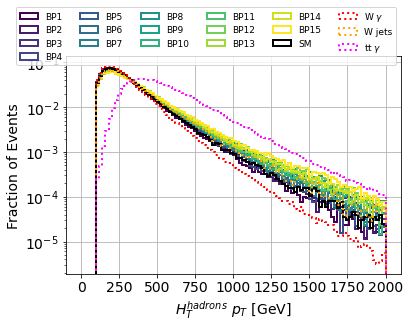

In [106]:
for i in range(len(photon_NP)):
    weights = np.ones_like(hadinfo_NP[i][:,0])/len(hadinfo_NP[i][:,0])
    plt.hist(hadinfo_NP[i][:,0], weights=weights, bins=100, range=[0,2000], lw=2, edgecolor=cmap(i), histtype='step', label=name[i], zorder=2)
    
weights = np.ones_like(hadinfo_SM[:,0])/len(hadinfo_SM[:,0])
plt.hist(hadinfo_SM[:,0], weights=weights, bins=100, range=[0,2000], lw=2, edgecolor='black', histtype='step', label="SM", zorder=2)
weights = np.ones_like(hadinfo_Wgamma[:,0])/len(hadinfo_Wgamma[:,0])
plt.hist(hadinfo_Wgamma[:,0], weights=weights, bins=100, range=[0,2000], lw=2,linestyle='dotted', edgecolor='red', histtype='step', label=r"W $\gamma$")
weights = np.ones_like(hadinfo_Wjets[:,0])/len(hadinfo_Wjets[:,0])
plt.hist(hadinfo_Wjets[:,0], weights=weights, bins=100, range=[0,2000], lw=2,linestyle='dotted', edgecolor='orange', histtype='step', label="W jets")
weights = np.ones_like(hadinfo_ttgamma[:,0])/len(hadinfo_ttgamma[:,0])
plt.hist(hadinfo_ttgamma[:,0], weights=weights, bins=100, range=[0,2000], lw=2,linestyle='dotted', edgecolor='magenta', histtype='step', label="tt $\gamma$")

plt.grid()  
plt.xlabel(r"$H_T^{hadrons}$ $p_T$ [GeV]",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.legend(loc='upper right',fontsize=9,bbox_to_anchor=(1., 1.25), ncol = 6)
plt.savefig('../graph/HadInfo_dist.png', bbox_inches='tight')

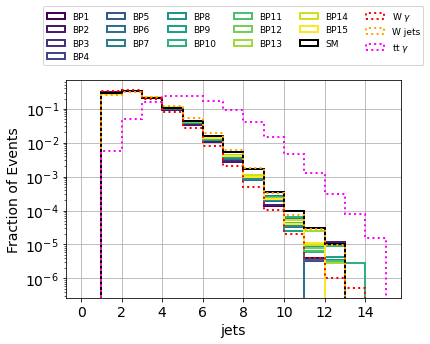

In [107]:
for i in range(len(photon_NP)):
    weights = np.ones_like(hadinfo_NP[i][:,1])/len(hadinfo_NP[i][:,1])
    plt.hist(hadinfo_NP[i][:,1], weights=weights, bins=15, range=[0,15], lw=2, edgecolor=cmap(i), histtype='step', label=name[i], zorder=2)
    
weights = np.ones_like(hadinfo_SM[:,1])/len(hadinfo_SM[:,1])
plt.hist(hadinfo_SM[:,1], weights=weights, bins=15, range=[0,15], lw=2, edgecolor='black', histtype='step', label="SM", zorder=2)
weights = np.ones_like(hadinfo_Wgamma[:,1])/len(hadinfo_Wgamma[:,1])
plt.hist(hadinfo_Wgamma[:,1], weights=weights, bins=15, range=[0,15], lw=2,linestyle='dotted', edgecolor='red', histtype='step', label=r"W $\gamma$")
weights = np.ones_like(hadinfo_Wjets[:,1])/len(hadinfo_Wjets[:,1])
plt.hist(hadinfo_Wjets[:,1], weights=weights, bins=15, range=[0,15], lw=2,linestyle='dotted', edgecolor='orange', histtype='step', label="W jets")
weights = np.ones_like(hadinfo_ttgamma[:,1])/len(hadinfo_ttgamma[:,1])
plt.hist(hadinfo_ttgamma[:,1], weights=weights, bins=15, range=[0,15], lw=2,linestyle='dotted', edgecolor='magenta', histtype='step', label="tt $\gamma$")

plt.grid()  
plt.xlabel(r"jets",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.legend(loc='lower center',fontsize=9,bbox_to_anchor=(0.5, 1.05), ncol = 6)
plt.savefig('../graph/jets_dist.png', bbox_inches='tight')

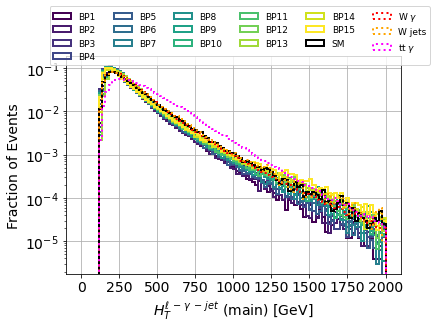

In [108]:
for i in range(len(photon_NP)):
    weights = np.ones_like(HT_main_NP[i])/len(HT_main_NP[i])
    plt.hist(HT_main_NP[i], weights=weights, bins=100, range=[0,2000], lw=2, edgecolor=cmap(i), histtype='step', label=name[i], zorder=2)
    
weights = np.ones_like(HT_main_SM)/len(HT_main_SM)
plt.hist(HT_main_SM, weights=weights, bins=100, range=[0,2000], lw=2, edgecolor='black', histtype='step', label="SM", zorder=2)
weights = np.ones_like(HT_main_Wgamma)/len(HT_main_Wgamma)
plt.hist(HT_main_Wgamma, weights=weights, bins=100, range=[0,2000], lw=2,linestyle='dotted', edgecolor='red', histtype='step', label=r"W $\gamma$")
weights = np.ones_like(HT_main_Wjets)/len(HT_main_Wjets)
plt.hist(HT_main_Wjets, weights=weights, bins=100, range=[0,2000], lw=2,linestyle='dotted', edgecolor='orange', histtype='step', label="W jets")
weights = np.ones_like(HT_main_ttgamma)/len(HT_main_ttgamma)
plt.hist(HT_main_ttgamma, weights=weights, bins=100, range=[0,2000], lw=2,linestyle='dotted', edgecolor='magenta', histtype='step', label="tt $\gamma$")

plt.grid()  
plt.xlabel(r"$H_T^{\ell \,-\, \gamma \,-\, jet}$ (main) [GeV]",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.legend(loc='upper right',fontsize=9,bbox_to_anchor=(1.1, 1.25), ncol = 6)
plt.savefig('../graph/Ht_dist.png', bbox_inches='tight')

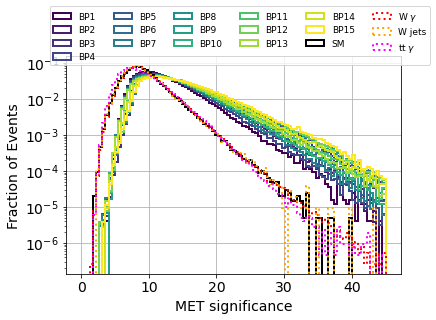

In [109]:
for i in range(len(photon_NP)):
    weights = np.ones_like(MET_sig_NP[i])/len(MET_sig_NP[i])
    plt.hist(MET_sig_NP[i], weights=weights, bins=100, range=[0,45], lw=2, edgecolor=cmap(i), histtype='step', label=name[i], zorder=2)
    
weights = np.ones_like(MET_sig_SM)/len(MET_sig_SM)
plt.hist(MET_sig_SM, weights=weights, bins=100, range=[0,45], lw=2, edgecolor='black', histtype='step', label="SM", zorder=2)
weights = np.ones_like(MET_sig_Wgamma)/len(MET_sig_Wgamma)
plt.hist(MET_sig_Wgamma, weights=weights, bins=100, range=[0,45], lw=2,linestyle='dotted', edgecolor='red', histtype='step', label=r"W $\gamma$")
weights = np.ones_like(MET_sig_Wjets)/len(MET_sig_Wjets)
plt.hist(MET_sig_Wjets, weights=weights, bins=100, range=[0,45], lw=2,linestyle='dotted', edgecolor='orange', histtype='step', label="W jets")
weights = np.ones_like(MET_sig_ttgamma)/len(MET_sig_ttgamma)
plt.hist(MET_sig_ttgamma, weights=weights, bins=100, range=[0,45], lw=2,linestyle='dotted', edgecolor='magenta', histtype='step', label="tt $\gamma$")

plt.grid()  
plt.xlabel(r"MET significance",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.legend(loc='upper right',fontsize=9,bbox_to_anchor=(1.1, 1.25), ncol = 6)
plt.savefig('../graph/MET_significance_dist.png', bbox_inches='tight')

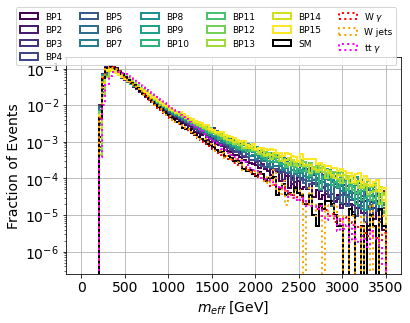

In [110]:
for i in range(len(photon_NP)):
    weights = np.ones_like(m_eff_NP[i])/len(m_eff_NP[i])
    plt.hist(m_eff_NP[i], weights=weights, bins=100, range=[0,3500], lw=2, edgecolor=cmap(i), histtype='step', label=name[i], zorder=2)
    
weights = np.ones_like(m_eff_SM)/len(m_eff_SM)
plt.hist(m_eff_SM, weights=weights, bins=100, range=[0,3500], lw=2, edgecolor='black', histtype='step', label="SM", zorder=2)
weights = np.ones_like(m_eff_Wgamma)/len(m_eff_Wgamma)
plt.hist(m_eff_Wgamma, weights=weights, bins=100, range=[0,3500], lw=2,linestyle='dotted', edgecolor='red', histtype='step', label=r"W $\gamma$")
weights = np.ones_like(m_eff_Wjets)/len(m_eff_Wjets)
plt.hist(m_eff_Wjets, weights=weights, bins=100, range=[0,3500], lw=2,linestyle='dotted', edgecolor='orange', histtype='step', label="W jets")
weights = np.ones_like(m_eff_ttgamma)/len(m_eff_ttgamma)
plt.hist(m_eff_ttgamma, weights=weights, bins=100, range=[0,3500], lw=2,linestyle='dotted', edgecolor='magenta', histtype='step', label="tt $\gamma$")

plt.grid()  
plt.xlabel(r"$m_{eff}$ [GeV]",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.legend(loc='upper right',fontsize=9,bbox_to_anchor=(1., 1.25), ncol = 6)
plt.savefig('../graph/Meff_dist.png', bbox_inches='tight')

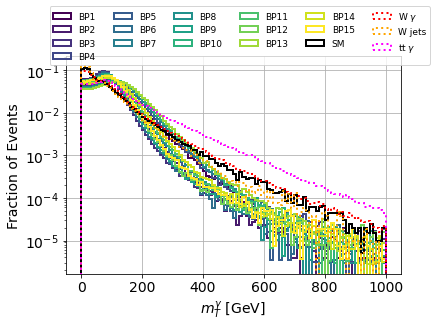

In [111]:
for i in range(len(photon_NP)):
    weights = np.ones_like(mT_photon_NP[i])/len(mT_photon_NP[i])
    plt.hist(mT_photon_NP[i], weights=weights, bins=100, range=[0,1000], lw=2, edgecolor=cmap(i), histtype='step', label=name[i], zorder=2)
    
weights = np.ones_like(mT_photon_SM)/len(mT_photon_SM)
plt.hist(mT_photon_SM, weights=weights, bins=100, range=[0,1000], lw=2, edgecolor='black', histtype='step', label="SM", zorder=2)
weights = np.ones_like(mT_photon_Wgamma)/len(mT_photon_Wgamma)
plt.hist(mT_photon_Wgamma, weights=weights, bins=100, range=[0,1000], lw=2,linestyle='dotted', edgecolor='red', histtype='step', label=r"W $\gamma$")
weights = np.ones_like(mT_photon_Wjets)/len(mT_photon_Wjets)
plt.hist(mT_photon_Wjets, weights=weights, bins=100, range=[0,1000], lw=2,linestyle='dotted', edgecolor='orange', histtype='step', label="W jets")
weights = np.ones_like(mT_photon_ttgamma)/len(mT_photon_ttgamma)
plt.hist(mT_photon_ttgamma, weights=weights, bins=100, range=[0,1000], lw=2,linestyle='dotted', edgecolor='magenta', histtype='step', label="tt $\gamma$")

plt.grid()  
plt.xlabel(r"$m_{T}^{\gamma}$ [GeV]",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.legend(loc='upper right',fontsize=9,bbox_to_anchor=(1.1, 1.25), ncol = 6)
plt.savefig('../graph/mt_photon_dist.png', bbox_inches='tight')

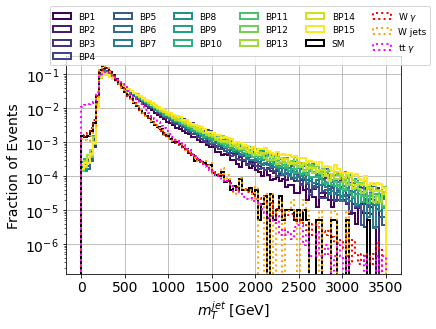

In [112]:
for i in range(len(photon_NP)):
    weights = np.ones_like(mT_jet_NP[i])/len(mT_jet_NP[i])
    plt.hist(mT_jet_NP[i], weights=weights, bins=100, range=[0,3500], lw=2, edgecolor=cmap(i), histtype='step', label=name[i], zorder=2)
    
weights = np.ones_like(mT_jet_SM)/len(mT_jet_SM)
plt.hist(mT_jet_SM, weights=weights, bins=100, range=[0,3500], lw=2, edgecolor='black', histtype='step', label="SM", zorder=2)
weights = np.ones_like(mT_jet_Wgamma)/len(mT_jet_Wgamma)
plt.hist(mT_jet_Wgamma, weights=weights, bins=100, range=[0,3500], lw=2,linestyle='dotted', edgecolor='red', histtype='step', label=r"W $\gamma$")
weights = np.ones_like(mT_jet_Wjets)/len(mT_jet_Wjets)
plt.hist(mT_jet_Wjets, weights=weights, bins=100, range=[0,3500], lw=2,linestyle='dotted', edgecolor='orange', histtype='step', label="W jets")
weights = np.ones_like(mT_jet_ttgamma)/len(mT_jet_ttgamma)
plt.hist(mT_jet_ttgamma, weights=weights, bins=100, range=[0,3500], lw=2,linestyle='dotted', edgecolor='magenta', histtype='step', label="tt $\gamma$")

plt.grid()  
plt.xlabel(r"$m_{T}^{jet}$ [GeV]",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.legend(loc='upper right',fontsize=9,bbox_to_anchor=(1.1, 1.25), ncol = 6)
plt.savefig('../graph/mt_Jet_dist.png', bbox_inches='tight')

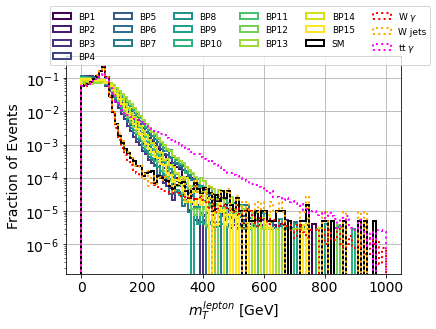

In [113]:
for i in range(len(photon_NP)):
    weights = np.ones_like(mT_lepton_NP[i])/len(mT_lepton_NP[i])
    plt.hist(mT_lepton_NP[i], weights=weights, bins=100, range=[0,1000], lw=2, edgecolor=cmap(i), histtype='step', label=name[i], zorder=2)
    
weights = np.ones_like(mT_lepton_SM)/len(mT_lepton_SM)
plt.hist(mT_lepton_SM, weights=weights, bins=100, range=[0,1000], lw=2, edgecolor='black', histtype='step', label="SM", zorder=2)
weights = np.ones_like(mT_lepton_Wgamma)/len(mT_lepton_Wgamma)
plt.hist(mT_lepton_Wgamma, weights=weights, bins=100, range=[0,1000], lw=2,linestyle='dotted', edgecolor='red', histtype='step', label=r"W $\gamma$")
weights = np.ones_like(mT_lepton_Wjets)/len(mT_lepton_Wjets)
plt.hist(mT_lepton_Wjets, weights=weights, bins=100, range=[0,1000], lw=2,linestyle='dotted', edgecolor='orange', histtype='step', label="W jets")
weights = np.ones_like(mT_lepton_ttgamma)/len(mT_lepton_ttgamma)
plt.hist(mT_lepton_ttgamma, weights=weights, bins=100, range=[0,1000], lw=2,linestyle='dotted', edgecolor='magenta', histtype='step', label="tt $\gamma$")

plt.grid()  
plt.xlabel(r"$m_{T}^{lepton}$ [GeV]",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.legend(loc='upper right',fontsize=9,bbox_to_anchor=(1.1, 1.25), ncol = 6)
plt.savefig('../graph/mt_Lepton_dist.png', bbox_inches='tight')

# Analysis

In [118]:
# LOW LEVEL VARIABLES ----------------------
# photon_SM[:,0] : PT
# photon_SM[:,1] : eta
# photon_SM[:,2] : phi

print(photon_SM.shape)
print(jet_SM.shape)
print(lepton_SM.shape)
print(MET_SM.shape)
#-------------------------------------------

# HIGH LEVEL VARIABLES ----------------------
# hadinfo_SM[:,0] : hadinfo
# hadinfo_SM[:,1] : number jets
# HT_main_SM : had info total
# MET_sig_SM : MET significace
# m_eff_SM : Effective mass
# mT_photon_SM : transverse mass
print(hadinfo_SM.shape)
print(HT_main_SM.shape)
print(MET_sig_SM.shape)
print(m_eff_SM.shape)
print(mT_photon_SM.shape)
print(mT_jet_SM.shape)
print(mT_lepton_SM.shape)
#-------------------------------------------

(200000, 3)
(200000, 3)
(200000, 3)
(200000, 3)
(200000, 2)
(200000,)
(200000,)
(200000,)
(200000,)
(200000,)
(200000,)


In [149]:
bp = 7
# LOW LEVEL VARIABLES ----------------------
# photon_NP[bp][:,0] : PT
# photon_NP[bp][:,1] : eta
# photon_NP[bp][:,2] : phi

print(photon_NP[bp].shape)
print(jet_NP[bp].shape)
print(lepton_NP[bp].shape)
print(MET_NP[bp].shape)
#-------------------------------------------

# HIGH LEVEL VARIABLES ----------------------
# hadinfo_NP[bp][:,0] : hadinfo
# hadinfo_NP[bp][:,1] : number jets
# HT_main_NP[bp] : had info total
# MET_sig_NP[bp] : MET significace
# m_eff_NP[bp] : Effective mass
# mT_photon_NP[bp] : transverse mass
print(hadinfo_NP[bp].shape)
print(HT_main_NP[bp].shape)
print(MET_sig_NP[bp].shape)
print(m_eff_NP[bp].shape)
print(mT_photon_NP[bp].shape)
print(mT_jet_NP[bp].shape)
print(mT_lepton_NP[bp].shape)
#-------------------------------------------

(293092, 3)
(293092, 3)
(293092, 3)
(293092, 3)
(293092, 2)
(293092,)
(293092,)
(293092,)
(293092,)
(293092,)
(293092,)


In [150]:
nobs = len(mT_lepton_SM)

In [225]:
df = pd.DataFrame()

lst = ['photon $p_T$ [GeV]', 'photon $\eta$', 'photon $\phi$',
       'jet $p_T$ [GeV]', 'jet $\eta$', 'jet $\phi$',
       'lepton $p_T$ [GeV]', 'lepton $\eta$', 'lepton $\phi$',
       'MET $p_T$ [GeV]', 'MET $\phi$',
       '$H_T$ (had) [GeV]', 'num_jets',
       '$H_T$ (main) [GeV]', 'MET sig [GeV]', '$m_{eff}$ [GeV]',
       '$m_T$ photon [GeV]', '$m_T$ jet [GeV]', '$m_T$ lepton [GeV]',
       '$\Delta \phi$ (MET-photon)', '$\Delta \phi$ (MET-jet)', '$\Delta \phi$ (MET-lepton)', 
       '$\Delta R$ (photon-jet)', '$\Delta R$ (photon-lepton)', '$\Delta R$ (lepton-jet)', 
       'SM=0 - NP=1']

df[lst[0]]= np.concatenate([photon_SM[:,0],photon_NP[bp][:nobs,0]])
df[lst[1]]= np.concatenate([photon_SM[:,1],photon_NP[bp][:nobs,1]])
df[lst[2]]= np.concatenate([photon_SM[:,2],photon_NP[bp][:nobs,2]])

df[lst[3]]= np.concatenate([jet_SM[:,0],jet_NP[bp][:nobs,0]])
df[lst[4]]= np.concatenate([jet_SM[:,1],jet_NP[bp][:nobs,1]])
df[lst[5]]= np.concatenate([jet_SM[:,2],jet_NP[bp][:nobs,2]])

df[lst[6]]= np.concatenate([lepton_SM[:,0],lepton_NP[bp][:nobs,0]])
df[lst[7]]= np.concatenate([lepton_SM[:,1],lepton_NP[bp][:nobs,1]])
df[lst[8]]= np.concatenate([lepton_SM[:,2],lepton_NP[bp][:nobs,2]])

df[lst[9]]= np.concatenate([MET_SM[:,0],MET_NP[bp][:nobs,0]])
df[lst[10]]= np.concatenate([MET_SM[:,2],MET_NP[bp][:nobs,2]])

df[lst[11]]= np.concatenate([hadinfo_SM[:,0],hadinfo_NP[bp][:nobs,0]])
df[lst[12]]= np.concatenate([hadinfo_SM[:,1],hadinfo_NP[bp][:nobs,1]])

df[lst[13]]= np.concatenate([HT_main_SM,HT_main_NP[bp][:nobs]])
df[lst[14]]= np.concatenate([MET_sig_SM,MET_sig_NP[bp][:nobs]])
df[lst[15]]= np.concatenate([m_eff_SM,m_eff_NP[bp][:nobs]])

df[lst[16]]= np.concatenate([mT_photon_SM,mT_photon_NP[bp][:nobs]])
df[lst[17]]= np.concatenate([mT_jet_SM,mT_jet_NP[bp][:nobs]])
df[lst[18]]= np.concatenate([mT_lepton_SM,mT_lepton_NP[bp][:nobs]])

df[lst[19]]= np.concatenate([phi_MET_photon_SM,phi_MET_photon_NP[bp][:nobs]])
df[lst[20]]= np.concatenate([phi_MET_jet_SM,phi_MET_jet_NP[bp][:nobs]])
df[lst[21]]= np.concatenate([phi_MET_lepton_SM,phi_MET_lepton_NP[bp][:nobs]])

df[lst[22]]= np.concatenate([deltaR_photon_jet_SM,deltaR_photon_jet_NP[bp][:nobs]])
df[lst[23]]= np.concatenate([deltaR_photon_lepton_SM,deltaR_photon_lepton_NP[bp][:nobs]])
df[lst[24]]= np.concatenate([deltaR_lepton_jet_SM,deltaR_lepton_jet_NP[bp][:nobs]])

df['bkg_flag']= bkg_flag

df[lst[25]]= np.concatenate([np.zeros(len(photon_SM)),np.ones(len(photon_NP[bp][:nobs]))])

df

,photon $p_T$ [GeV],photon $\eta$,photon $\phi$,jet $p_T$ [GeV],jet $\eta$,jet $\phi$,lepton $p_T$ [GeV],lepton $\eta$,lepton $\phi$,MET $p_T$ [GeV],...,$m_T$ jet [GeV],$m_T$ lepton [GeV],$\Delta \phi$ (MET-photon),$\Delta \phi$ (MET-jet),$\Delta \phi$ (MET-lepton),$\Delta R$ (photon-jet),$\Delta R$ (photon-lepton),$\Delta R$ (lepton-jet),bkg_flag,SM=0 - NP=1
0,12.30,2.102,-2.640,277.40,0.309,-0.144,62.97,1.864,-3.091,241.73,...,508.208040,23.774707,0.258,2.754,0.193,3.073250,0.509946,3.332092,1.0,0.0
1,19.65,-0.034,2.512,284.92,-0.875,-0.986,151.82,-0.509,1.995,114.55,...,354.243591,72.508431,0.040,3.538,0.557,2.909388,0.702078,3.003384,1.0,0.0
2,14.88,1.119,-1.349,176.83,2.457,-0.259,37.05,0.929,-2.610,163.37,...,338.439394,73.104899,4.044,2.954,5.305,1.725788,1.275234,2.803923,1.0,0.0
3,18.99,0.587,-2.634,138.46,0.600,1.371,21.06,1.454,-2.828,111.44,...,242.539059,65.831120,1.300,2.705,1.494,2.278222,0.888440,2.252364,1.0,0.0
4,62.71,-0.144,2.679,157.32,0.248,0.038,22.12,1.172,1.521,142.18,...,89.822819,47.418325,2.031,0.610,0.873,2.669934,1.752946,1.747302,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399995,46.76,-0.878,-1.238,220.38,1.043,2.331,10.80,1.127,1.281,387.35,...,563.437524,90.744705,0.964,2.605,1.555,3.325213,3.219532,1.053355,0.0,1.0
399996,22.41,1.590,2.915,162.18,2.760,-0.474,10.83,0.551,-2.423,113.53,...,270.983893,42.474382,0.356,3.033,4.982,3.121732,1.404598,2.945892,0.0,1.0
399997,31.55,-1.905,0.828,132.48,-3.158,-0.474,34.81,-1.653,3.015,123.70,...,255.831843,27.743264,1.761,3.063,0.426,1.806990,2.201471,3.173720,0.0,1.0
399998,28.01,0.112,-0.061,133.93,0.928,-0.618,32.69,1.176,2.871,162.69,...,284.352573,14.343384,3.129,3.686,0.197,0.987980,3.119090,2.805169,0.0,1.0


In [226]:
# to normalize
scaler = preprocessing.MinMaxScaler()

df = scaler.fit_transform(df)

X_mon = df[:,0:25]
y_mon = df[:,-1]

# divide into train-val and test data samples
test_ratio = 1./3
val_ratio = 0.25

X_mon_aux, X_mon_test, y_mon_aux, y_mon_test = train_test_split(X_mon,
                                                                y_mon,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_mon,
                                                                shuffle=True)

X_mon_train, X_mon_val, y_mon_train, y_mon_val = train_test_split(X_mon_aux,
                                                                  y_mon_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_mon_aux,
                                                                  shuffle=True)
print('')
print('X_mon_train : ', X_mon_train.shape)
print('y_mon_train : ', y_mon_train.shape)
print('X_mon_val : ', X_mon_val.shape)
print('y_mon_val : ', y_mon_val.shape)
print('X_mon_test : ', X_mon_test.shape)
print('y_mon_test : ', y_mon_test.shape)
print('')


X_mon_train :  (199999, 25)
y_mon_train :  (199999,)
X_mon_val :  (66667, 25)
y_mon_val :  (66667,)
X_mon_test :  (133334, 25)
y_mon_test :  (133334,)



In [227]:
# XGBoost with only the kinematic variables of the leptons

# CLASSIFIER
classifier = XGBClassifier(
    n_estimators  = 500,
    learning_rate = 0.1,
    reg_lambda    = 0.0, reg_alpha = 0.0,
    gamma = 0.0, objective = 'binary:logistic',
    max_depth = 5)

# FIT
classifier.fit(X_mon_train, y_mon_train, 
               eval_set = [(X_mon_train, y_mon_train), (X_mon_val, y_mon_val)],
               eval_metric = 'logloss', early_stopping_rounds = 50,#early stopping
               verbose  =True)

# PREDICTIONS
y_pred_xg = classifier.predict_proba(X_mon_test).T[1]


# ROC
fpr_mon_xg, tpr_mon_xg, _ = roc_curve(y_mon_test, y_pred_xg)
roc_auc_xg = auc(fpr_mon_xg, tpr_mon_xg)

[0]	validation_0-logloss:0.64626	validation_1-logloss:0.64641
[1]	validation_0-logloss:0.60740	validation_1-logloss:0.60769


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[2]	validation_0-logloss:0.57465	validation_1-logloss:0.57524
[3]	validation_0-logloss:0.54619	validation_1-logloss:0.54681
[4]	validation_0-logloss:0.52237	validation_1-logloss:0.52309
[5]	validation_0-logloss:0.50033	validation_1-logloss:0.50118
[6]	validation_0-logloss:0.48210	validation_1-logloss:0.48320
[7]	validation_0-logloss:0.46576	validation_1-logloss:0.46701
[8]	validation_0-logloss:0.45068	validation_1-logloss:0.45204
[9]	validation_0-logloss:0.43809	validation_1-logloss:0.43962
[10]	validation_0-logloss:0.42657	validation_1-logloss:0.42821
[11]	validation_0-logloss:0.41665	validation_1-logloss:0.41842
[12]	validation_0-logloss:0.40712	validation_1-logloss:0.40906
[13]	validation_0-logloss:0.39895	validation_1-logloss:0.40108
[14]	validation_0-logloss:0.39130	validation_1-logloss:0.39351
[15]	validation_0-logloss:0.38461	validation_1-logloss:0.38694
[16]	validation_0-logloss:0.37869	validation_1-logloss:0.38108
[17]	validation_0-logloss:0.37286	validation_1-logloss:0.37544


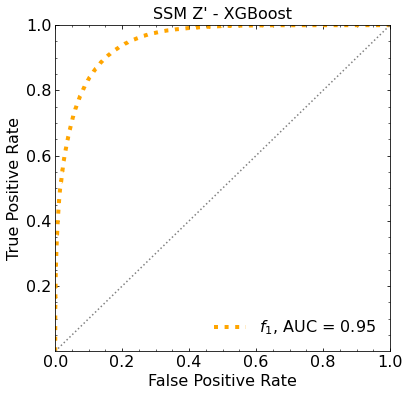

In [228]:
# PLOT THE ROC WITH AUC
fig = plt.figure(figsize=(6, 6))
gs  = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax0.minorticks_on()


plt.plot(fpr_mon_xg, tpr_mon_xg, label="$f_{1}$, AUC = %0.2f" % roc_auc_xg, color="orange",ls=":",lw=4)
plt.plot([0,1],[0,1],ls=":",color="grey")
plt.ylabel("True Positive Rate",fontsize=16)
plt.xlabel("False Positive Rate",fontsize=16)
plt.legend()
plt.title(r"SSM Z' - XGBoost",fontsize=16)
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)

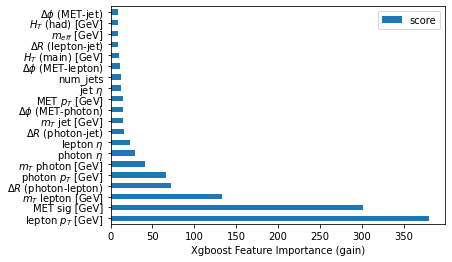

In [229]:
fig, ax = plt.subplots()

feature_important = classifier.get_booster().get_score(importance_type='gain')
values = list(feature_important.values())

data = pd.DataFrame(data=values, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(20, columns="score").plot(kind='barh', ax = ax) ## plot top 20 features

ax.set_xlabel("Xgboost Feature Importance (gain)")
ax.set_yticklabels(np.asarray(lst)[np.argsort(values)[::-1][:20]])

plt.savefig('../graph/BP' + str(bp + 1) + '_featureImportance.png')

Classification score:


Text(0.5, 1.0, 'Multivariate monian distributions, $\\mathcal{N}_{2}$')

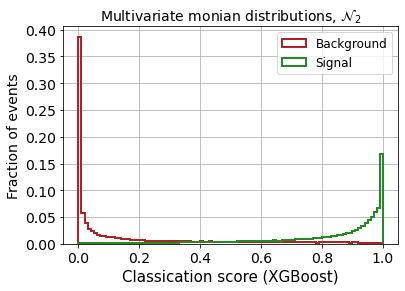

In [230]:
# XGBoost

########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_xg[i])
    else:
        pred_XG_NP.append(y_pred_xg[i])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 100, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 100, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)
plt.title('Multivariate monian distributions, $\mathcal{N}_{2}$', fontsize=14)
#plt.savefig('../graph/' + '2monian-output.pdf', format="pdf", bbox_inches="tight")

In [231]:
# number of expected background events per ensemble
B_expected = (1674.4584461333332 + 59997.68515734306 + 64899.72420521739) 

S_expected = [100, 135.098998848, 892.526425]

In [232]:
# Working point
treshold=0.993


signalok = 0

for i in range(len(pred_XG_NP)):
    if pred_XG_NP[i] > treshold:
        signalok += 1
        
backok = 0

for i in range(len(pred_XG_SM)):
    if pred_XG_SM[i] > treshold:
        backok += 1  
        
#print(signalok)
#print(backok)

frac_sig = signalok / len(pred_XG_NP)
frac_bkg = backok / len(pred_XG_SM)

Sexp = S_expected[1] * frac_sig#*(3000./139)
Bexp = B_expected * frac_bkg#*(3000./139)

print('treshold: ', treshold)
print('Sexp: ', Sexp)
print('Bexp: ', Bexp)
print('SsqrtB: ', Sexp/(Bexp)**0.5)
print('Sig stat full: ', ( 2.* ( (Sexp+Bexp)*np.log(1 + (Sexp/Bexp) ) - Sexp ) )**0.5 )

treshold:  0.993
Sexp:  19.45069829956551
Bexp:  49.263761965031044
SsqrtB:  2.771222592721228
Sig stat full:  2.6136084705165223


# Binned likelihood

In [233]:
##############
# PARAMETERS #
##############

# requested number of ensembles
n_ensembles = 5000


## LQ up 1400 GeV:
#S_expected = 7 # 6.6095293118432

# ratio S_expected/B_expected (signal ratio)
#SB_ratio = [0.0006, 0.001, 0.0016, 0.0025, 0.005, 0.0075, 0.01, 0.025]

# SOME USEFUL DERIVATED PARAMETERS:

# S/\sqrt{B}
SB_ratio = [ S_expected[iii]/(1.*B_expected) for iii in range(len(S_expected)) ]

# S/\sqrt{B}
SsqrtB = [ S_expected[iii]/(B_expected)**0.5 for iii in range(len(S_expected)) ]

In [234]:
#################################
# BINNED POISSON LOG-LIKELIHOOD #
#################################

store_Z_bins_XG_16bins = []
store_Z_bins_XG_50bins = []
store_Z_bins_XG_100bins = []


for iii in range(len(S_expected)):

    print('B_expected: ', B_expected)
    print('S_expected: ', S_expected[iii])
    print(r'S/$\sqrt{B}$: ', SsqrtB[iii])

    # Les't use an integer number of possible ensembles
    N_ensembles_back = len(pred_XG_SM) / B_expected
    N_events_back = N_ensembles_back * B_expected

    N_ensembles_sig = len(pred_XG_NP) / S_expected[iii]
    N_events_sig = N_ensembles_sig * S_expected[iii]
    
    
    
    ############
    # 16 bins #
    ############
    
    #Let's find out the expected number of B and S events in each bin:

    # bin the parameter space of all background events
    hist_back, binedges_back = np.histogramdd([pred_XG_SM], bins=(16), range = [[0,1]])
    # now divide by the number of possible ensembles
    back_prom = hist_back.T.ravel()/N_ensembles_back

    # same for signal
    hist_sig, binedges_sig = np.histogramdd([pred_XG_NP], bins=(16), range = [[0,1]])
    sig_prom = hist_sig.T.ravel()/N_ensembles_sig

        

    # If a bins has no expected background events replace that zero for the minimum B_bin=/=0

    # find the minimum
    back_prom_noceros = []
    for i in range(len(back_prom)):
        if back_prom[i]!=0:
            back_prom_noceros.append(back_prom[i])

    min_back = min(back_prom_noceros)

    # replace the zeros
    for i in range(len(back_prom)):
        if back_prom[i]==0:
            back_prom[i] = min_back

    # then the signif Z^binned-Asimov:
    Z_bins_16bins = ( 2* sum( ( (back_prom + sig_prom) * np.log( 1 + (sig_prom / back_prom) ) ) - sig_prom ) )**0.5
    #Z_bins_50bins = ( 2* sum( ( back_prom * np.log( back_prom/(sig_prom + back_prom) ) ) + sig_prom ) )**0.5

    store_Z_bins_XG_16bins.append(Z_bins_16bins)

    print('Z_bins_16bins : ', Z_bins_16bins)


    
    ############
    # 50 bins #
    ############
    
    #Let's find out the expected number of B and S events in each bin:

    # bin the parameter space of all background events
    hist_back, binedges_back = np.histogramdd([pred_XG_SM], bins=(50), range = [[0,1]])
    # now divide by the number of possible ensembles
    back_prom = hist_back.T.ravel()/N_ensembles_back

    # same for signal
    hist_sig, binedges_sig = np.histogramdd([pred_XG_NP], bins=(50), range = [[0,1]])
    sig_prom = hist_sig.T.ravel()/N_ensembles_sig

        

    # If a bins has no expected background events replace that zero for the minimum B_bin=/=0

    # find the minimum
    back_prom_noceros = []
    for i in range(len(back_prom)):
        if back_prom[i]!=0:
            back_prom_noceros.append(back_prom[i])

    min_back = min(back_prom_noceros)

    # replace the zeros
    for i in range(len(back_prom)):
        if back_prom[i]==0:
            back_prom[i] = min_back

    # then the signif Z^binned-Asimov:
    Z_bins_50bins = ( 2* sum( ( (back_prom + sig_prom) * np.log( 1 + (sig_prom / back_prom) ) ) - sig_prom ) )**0.5
    #Z_bins_50bins = ( 2* sum( ( back_prom * np.log( back_prom/(sig_prom + back_prom) ) ) + sig_prom ) )**0.5

    store_Z_bins_XG_50bins.append(Z_bins_50bins)

    print('Z_bins_50bins : ', Z_bins_50bins)
    
    
    ############
    # 100 bins #
    ############
    
    #Let's find out the expected number of B and S events in each bin:

    # bin the parameter space of all background events
    hist_back, binedges_back = np.histogramdd([pred_XG_SM], bins=(100), range = [[0,1]])
    # now divide by the number of possible ensembles
    back_prom = hist_back.T.ravel()/N_ensembles_back

    # same for signal
    hist_sig, binedges_sig = np.histogramdd([pred_XG_NP], bins=(100), range = [[0,1]])
    sig_prom = hist_sig.T.ravel()/N_ensembles_sig

        

    # If a bins has no expected background events replace that zero for the minimum B_bin=/=0

    # find the minimum
    back_prom_noceros = []
    for i in range(len(back_prom)):
        if back_prom[i]!=0:
            back_prom_noceros.append(back_prom[i])

    min_back = min(back_prom_noceros)

    # replace the zeros
    for i in range(len(back_prom)):
        if back_prom[i]==0:
            back_prom[i] = min_back

    # then the signif Z^binned-Asimov:
    Z_bins_100bins = ( 2* sum( ( (back_prom + sig_prom) * np.log( 1 + (sig_prom / back_prom) ) ) - sig_prom ) )**0.5
    #Z_bins_100bins = ( 2* sum( ( back_prom * np.log( back_prom/(sig_prom + back_prom) ) ) + sig_prom ) )**0.5

    store_Z_bins_XG_100bins.append(Z_bins_100bins)

    print('Z_bins_100bins : ', Z_bins_100bins)
    
    
    print('\n ----------------------------------- \n')

B_expected:  126571.86780869379
S_expected:  100
S/$\sqrt{B}$:  0.2810809453431594
Z_bins_16bins :  1.3067888224782502
Z_bins_50bins :  1.7893024900297847
Z_bins_100bins :  2.0080517775311173

 ----------------------------------- 

B_expected:  126571.86780869379
S_expected:  135.098998848
S/$\sqrt{B}$:  0.37973754311110247
Z_bins_16bins :  1.7622719310203758
Z_bins_50bins :  2.404939841934225
Z_bins_100bins :  2.6917469783500665

 ----------------------------------- 

B_expected:  126571.86780869379
S_expected:  892.526425
S/$\sqrt{B}$:  2.5087217128275046
Z_bins_16bins :  11.232661661208203
Z_bins_50bins :  14.543915920380027
Z_bins_100bins :  15.74373707284817

 ----------------------------------- 



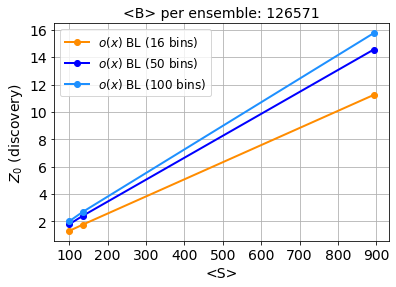

In [235]:
#########
# PLOTS #
#########

posX = []

for i in range(len(S_expected)):
    posX.append( (B_expected*SB_ratio[i]) / ( B_expected )**0.5 )


    
plt.figure()
lw = 2

plt.plot(S_expected, store_Z_bins_XG_16bins, '-o', color='darkorange', lw=lw, label=r'$o(x)$ BL (16 bins)') 
plt.plot(S_expected, store_Z_bins_XG_50bins, '-o', color='blue', lw=lw, label=r'$o(x)$ BL (50 bins)') 
plt.plot(S_expected, store_Z_bins_XG_100bins, '-o', color='dodgerblue', lw=lw, label=r'$o(x)$ BL (100 bins)') 

#plt.xlim([0.5, 10])
#plt.ylim([-0.5, 7.5])
#plt.xscale('log')
plt.xlabel('<S>', fontsize=14)
plt.ylabel('$Z_{0}$ (discovery)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.title('<B> per ensemble: %0.2d' % B_expected, fontsize=14)
plt.legend(fontsize=12)